# Example: Cargo flow plots 

This example replicates SignalOcean's "Cargo Flows" dashboard, which visualizes the flow of cargo of either imports/exports from a specific load area and of a specific vessel class. To import the data, this example showcases two different importing methods:

**a.** From a call to the VoyagesAPI (Voyages).<br>
**b.** From a persisted, local, database (Vessels).

Persisting the vessel data is considered good-practise while working with the SDK and an example implementation can be found in CombinedExamples/PersistVessels.ipynb. It is required to run it before proceeding with this example.

## Setup

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

from signal_ocean.voyages import VoyagesAPI
from signal_ocean import VesselClassAPI, VesselClassFilter, Connection
from datetime import datetime, date, timedelta, timezone

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [2]:
signal_ocean_api_key = '' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

## 1. Importing the data

### 1.1. Calling VoyagesAPI:

Specify call parameters:

In [3]:
area_of_interest = 'Australia West'
vessel_class = 'Capesize'
date_from = date(2018,12,31)         # refers to first_load_arrival_date_from
activity = 'export'                  # either "import" or "export"

Instantiate APIs,

In [4]:
voyages_api = VoyagesAPI(connection)
vessel_class_api = VesselClassAPI(connection)

Extract voyages filtered by vessel class and events,

In [5]:
vessel_class_id = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0].id

voyages = voyages_api.get_voyages_by_advanced_search(vessel_class_id=vessel_class_id, first_load_arrival_date_from=date_from)
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

Append necessary cargo flow events:

In [6]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

Filter voyages by either "imports" or "exports":

In [7]:
def get_voyage_imports_exports(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise SyntaxError('activity must take values "import" or "export".')
        
voyages = get_voyage_imports_exports(voyages, activity)

Clean any predicted data and keep only current/historical. Visualizing the filtered voyages dataframe:

In [8]:
voyages = voyages[pd.to_datetime(voyages['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)]
voyages

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,vessel_name,...,fixture_date,fixture_is_coa,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,laden_distance,load_area,load_country,discharge_country
104,9165322,68,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED41A3F00', port_id=8...",I8BDA0AVED41A3F00,Great Sunrise,...,NaT,None,None,None,None,3568.06,3721.32,Australia West,Australia,Japan
105,9165322,69,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4695900', port_id=8...",I8BDA0AVED4695900,Great Sunrise,...,NaT,None,None,None,None,3559.00,3699.87,Australia West,Australia,Japan
106,9165322,70,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4B87300', port_id=8...",I8BDA0AVED4B87300,Great Sunrise,...,NaT,None,None,None,None,3567.84,3639.62,Australia West,Australia,Japan
110,9165322,74,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6930F00', port_id=8...",I8BDA0AVED6930F00,Great Sunrise,...,NaT,None,None,None,None,3537.96,3562.22,Australia West,Australia,Japan
111,9165322,75,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6E22900', port_id=8...",I8BDA0AVED6E22900,Great Sunrise,...,NaT,None,None,None,None,3565.06,3601.37,Australia West,Australia,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21222,9891907,1,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7A7EA00', port_id=6...",I96F043VED7A7EA00,Southern Cross,...,NaT,None,None,None,None,3647.09,3751.90,Australia West,Australia,Japan
21223,9891907,2,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7F70400', port_id=3...",I96F043VED7F70400,Southern Cross,...,NaT,None,None,None,None,3579.16,4083.66,Australia West,Australia,Japan
21237,9906013,2,3,70,1,-1,False,"(VoyageEvent(id='I97275DSED81E9100', port_id=6...",I97275DVED81E9100,Trust Qingdao,...,NaT,None,None,None,None,3754.81,3506.24,Australia West,Australia,China
21239,9906025,1,3,70,1,-1,False,"(VoyageEvent(id='I972769SED7CF7700', port_id=3...",I972769VED7CF7700,H1519,...,NaT,None,None,None,None,3833.06,3618.56,Australia West,Australia,China


### 1.2. Import Persisted Vessel data:

Read the persisted vessel database created using the PersistVessels.ipynb example. This helps reduce runtime duration since vessel details are not necessarily updated very frequently.

In [9]:
db_conn = sqlite3.connect('AllVessels.db')

query = db_conn.execute("SELECT imo, deadweight FROM Vessels")
cols = [column[0] for column in query.description]
vessels = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)

db_conn.close()
vessels.tail(5)

,imo,deadweight
43500,9920411,60000
43501,9922067,2874
43502,9922859,4820
43503,9922861,4820
43504,9968956,13245


### 1.3. Merge Voyage & Vessel data:

Merge voyage and vessel dataframes using vessel IMO as key and keep only useful information,

In [10]:
voyages_merged = voyages.merge(vessels, on='imo')
voyages_merged = voyages_merged[['first_load_arrival_date','imo','voyage_number','deadweight','load_area','load_country','discharge_country']].sort_values('first_load_arrival_date').reset_index(drop=True)
voyages_merged

,first_load_arrival_date,imo,voyage_number,deadweight,load_area,load_country,discharge_country
0,2018-12-31 03:55:12+00:00,9718210,18,180377,Australia West,Australia,China
1,2018-12-31 03:56:54+00:00,9493626,56,175931,Australia West,Australia,China
2,2018-12-31 03:59:02+00:00,9758648,16,207392,Australia West,Australia,China
3,2018-12-31 07:52:47+00:00,9579872,41,179178,Australia West,Australia,China
4,2018-12-31 11:58:07+00:00,9331517,64,203280,Australia West,Australia,China
...,...,...,...,...,...,...,...
9800,2021-07-08 14:12:08.831000+00:00,9860972,3,208214,Australia West,Australia,China
9801,2021-07-08 14:34:06+00:00,9531870,94,207993,Australia West,Australia,China
9802,2021-07-08 14:49:25.330000+00:00,9595591,71,179461,Australia West,Australia,China
9803,2021-07-08 15:04:53.168000+00:00,9735165,49,209472,Australia West,Australia,China


## 2. Plotting the data

### 2.1. Plot: Volume per Week

The volume per week plot is very useful in getting a high-level overview of cargo flows for the provided filters.<br>
In order to plot it, we need to create bins of weeks-of-interest, which start from a Monday, end on a Sunday and are time-beggining. They can be changed to any supported frequency by modifying the *freq* parameter:

In [11]:
dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') 
weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])
weeks_from_monday

,first_load_arrival_date
0,2018-12-31 00:00:00+00:00
1,2019-01-07 00:00:00+00:00
2,2019-01-14 00:00:00+00:00
3,2019-01-21 00:00:00+00:00
4,2019-01-28 00:00:00+00:00
...,...
127,2021-06-07 00:00:00+00:00
128,2021-06-14 00:00:00+00:00
129,2021-06-21 00:00:00+00:00
130,2021-06-28 00:00:00+00:00


Group voyages deadweight into weekly bins (starting from Monday) and take the sum.

In [12]:
volume_per_week = voyages_merged[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()
volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,2045253
1,2019-01-07 00:00:00+00:00,11497005
2,2019-01-14 00:00:00+00:00,11147890
3,2019-01-21 00:00:00+00:00,14712413
4,2019-01-28 00:00:00+00:00,11729516
...,...,...
128,2021-06-14 00:00:00+00:00,14548613
129,2021-06-21 00:00:00+00:00,14342634
130,2021-06-28 00:00:00+00:00,15432892
131,2021-07-05 00:00:00+00:00,12318730


Filter the grouped output using the weeks-of-interest bins that were generated at the start of this section.

In [13]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes
volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,2.045253
1,2019-01-07 00:00:00+00:00,11.497005
2,2019-01-14 00:00:00+00:00,11.147890
3,2019-01-21 00:00:00+00:00,14.712413
4,2019-01-28 00:00:00+00:00,11.729516
...,...,...
127,2021-06-07 00:00:00+00:00,14.424304
128,2021-06-14 00:00:00+00:00,14.548613
129,2021-06-21 00:00:00+00:00,14.342634
130,2021-06-28 00:00:00+00:00,15.432892


Plot the volume per week chart as follows:

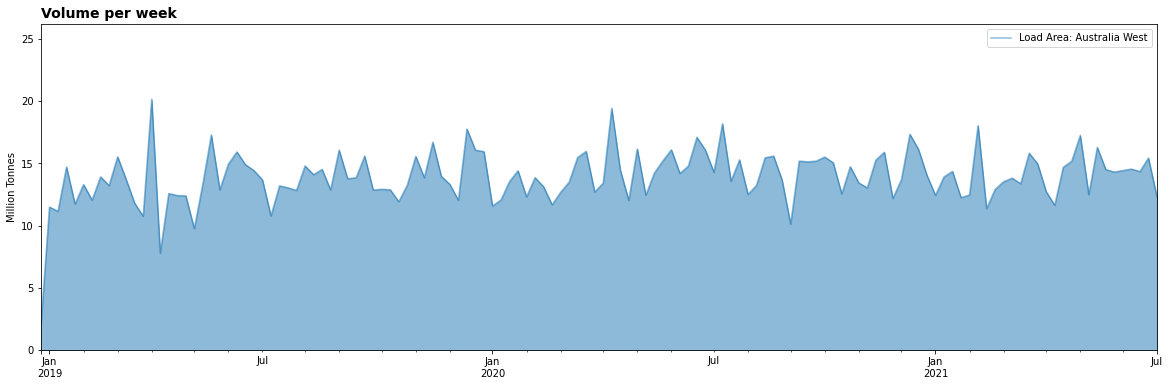

In [14]:
fig, axs = plt.subplots(figsize=(20,6))
volume_per_week.plot(ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False, xlabel='', ylabel='Million Tonnes')

# Properties
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])
axs.set_ylim([0, 1.3*max(volume_per_week['deadweight'])]);

### 2.2. Plot: Countries of Destination

The countries of destination plot gives insight to which country the cargo from the specified load area ends up in and in what amount. <br>
To plot it, we need to re-filter the voyages dataframe by date in order to get the date-range of interest. Also, we need to group voyages by discharge country and calculate the percentage of deadweight being imported/exported compared to all the other countries.

In [15]:
date_from = date(2021,1,1)  # specify new starting date

countries_of_destination = voyages_merged.loc[voyages_merged['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
countries_of_destination = countries_of_destination.groupby(pd.Grouper(key='discharge_country')).sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)
countries_of_destination['%_deadweight'] = 100*countries_of_destination['deadweight']/countries_of_destination['deadweight'].sum()
countries_of_destination

,discharge_country,imo,voyage_number,deadweight,%_deadweight
0,Netherlands,9872107,3,180000,0.047398
1,Malaysia,38318582,318,743741,0.195844
2,Australia,104148492,660,1941510,0.511245
3,Indonesia,135633680,552,2644526,0.696365
4,Viet Nam,315446209,1790,5953342,1.567654
5,Taiwan,549154403,3064,11684882,3.076902
6,"Korea, Republic of",1085230849,5944,22445804,5.910504
7,Japan,1396460863,6243,28602458,7.531695
8,China,15603022905,87364,305564971,80.462392


Plot the countries of destination chart as follows:

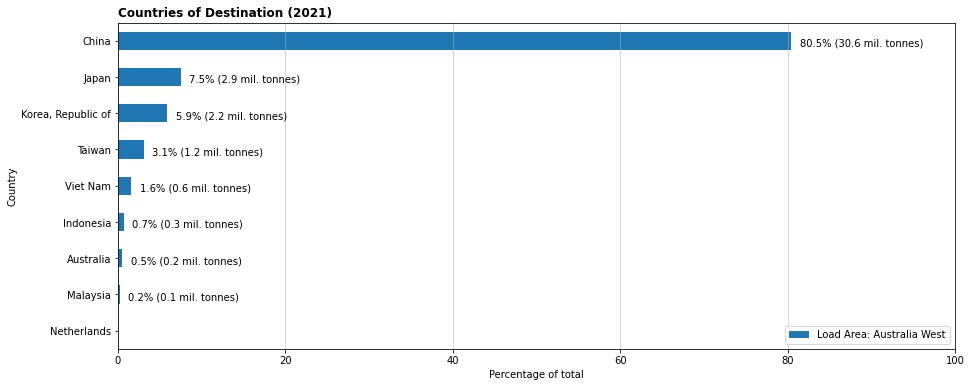

In [16]:
fig, axs = plt.subplots(figsize=(15,6))
countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left', fontweight='bold')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

axs.set_xlim([0, 100])
axs.grid(which='major', axis='x', linewidth=0.5)

for i, v in enumerate(round(countries_of_destination['%_deadweight'],1)): # attach annotations at end of bars
    if countries_of_destination['%_deadweight'][i] >= 0.1:
        dwt = countries_of_destination['deadweight'][i]
        axs.text(v + 1, i - 0.15, f'{v}% ({round(dwt/10e6,1)} mil. tonnes)', color='black')

### 2.3. Plot: Volume Per Month 

The volume per month plot is useful in visualizing how the volume of cargo being transported from/to the specified area changes from year to year on a monthly level.<br>
To plot it, the first thing to do is specify how many years back, from the current year, we want to compare and aggregate the voyages deadweight into the respective date-range bins.

In [17]:
years_back = 3 # specify how many years back to compare the monthly cargo volumes

# Create a new dataframe and aggregate cargo by month and year (multiIndex)
vpm = voyages_merged[['first_load_arrival_date', 'deadweight']].set_index('first_load_arrival_date')
volume_per_month = vpm.groupby([vpm.index.month, vpm.index.year]).sum()
volume_per_month.index.rename(['month','year'], inplace=True)

# Filter to last "years_back" years
years = volume_per_month.index.get_level_values('year')
volume_per_month = volume_per_month[years > (date.today().year - years_back)]

volume_per_month['deadweight'] /= 1e6 # in million tonnes
volume_per_month

deadweight
month year            
1     2019   54.537220
      2020   57.249031
      2021   55.943235
2     2019   52.797782
      2020   52.523605
      2021   57.327632
3     2019   64.467135
      2020   63.861629
      2021   63.757555
4     2019   47.993864
      2020   64.988036
      2021   61.424780
5     2019   61.488027
      2020   63.948967
      2021   63.512448
6     2019   63.809203
      2020   66.090437
      2021   62.770447
7     2019   55.929917
      2020   66.453825
      2021   15.025137
8     2019   63.300021
      2020   63.223104
9     2019   59.815629
      2020   60.351136
10    2019   58.553987
      2020   62.025956
11    2019   62.853948
      2020   60.920030
12    2019   66.694795
      2020   67.546457

We can now plot the volume per month chart as follows:

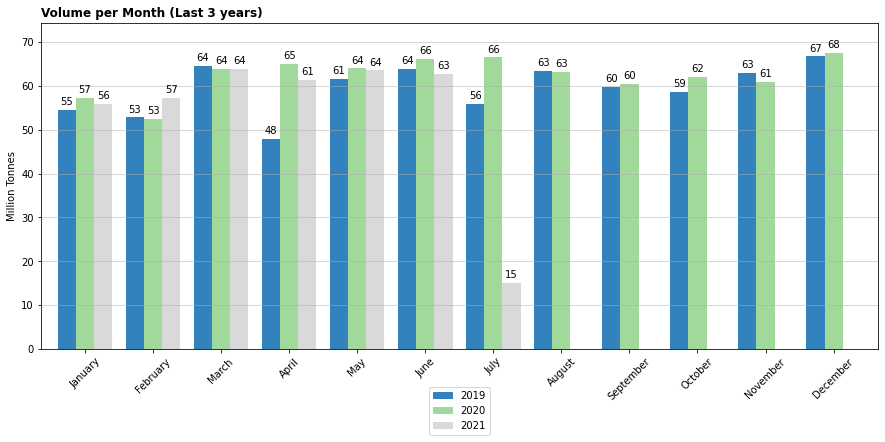

In [18]:
fig, axs = plt.subplots(figsize=(15,6))
volume_per_month.unstack().plot(kind='bar', ax=axs, width=0.8, colormap='tab20c')

# Properties
axs.set_title(f'Volume per Month (Last {years_back} years)', loc='left', fontweight='bold')
axs.set_ylabel('Million Tonnes')
axs.set_xlabel('')
axs.legend(years.unique(), loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs.set_ylim([0, 1.1*max(volume_per_month['deadweight'])])

months = list(map(str, volume_per_month.index.get_level_values('month').array.unique()))
months = [datetime.strftime(datetime.strptime(m, '%m'), '%B') for m in months]
axs.set_xticklabels(months, rotation=45)

axs.grid(which='major', axis='y', linewidth=0.5)

for bar in axs.patches:
    if bar.get_height() > 0:
        axs.annotate(format(bar.get_height(), '0.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')